In [1]:
import math as m
import h5py 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import h5py
class Antenna:
    """ antenna with location and timeseries of Efield"""
    def __init__(self,x,y,z,name=""):
        self.x = x
        self.y = y
        self.z = z
        self.name = name

class REvent:
    """ An interface class for reading simulations """
    def __init__(self,filename):
        self.reasfile = filename
        if '.reas' in filename:
            self.reasfile = filename
            self.parse_reas()
        elif '.hdf5' in filename:
            self.hdf5file = filename
            self.parse_hdf5()

    def parse_reas(self):
        """ parse *reas file """
        f = open(self.reasfile)
        lines = f.readlines()
        for l in lines:
            if 'ShowerZenithAngle' in l:
                self.zenith = float(l.split()[2])
            if 'ShowerAzimuthAngle' in l:
                self.azimuth = float(l.split()[2]) + 180
                if self.azimuth > 360:
                    self.azimuth = self.azimuth - 360
            if 'DepthOfShowerMaximum' in l:
                self.xmax = float(l.split()[2])
            if 'PrimaryParticleEnergy' in l:
                self.energy = float(l.split()[2])/1e18
            if 'PrimaryParticleType' in l:
                self.part_id = int(l.split()[2])
            if 'MagneticFieldInclinationAngle' in l:
                self.Binc = float(l.split()[2])
            if 'MagneticFieldStrength' in l:
                self.Bmag = float(l.split()[2])
        self.parse_reas_antenas()
        self.set_unit_vectors()

    def parse_reas_antenas(self):
        """Parse the antennas by reas """
        self.listfile = self.reasfile.replace('.reas','.list')
        f = open(self.listfile)
        lines = f.readlines()
        self.antennas = []
        print('reading ' +  str(len(lines)) + ' antennas')
        for l in lines:
            a = Antenna(float(l.split()[2])/100,float(l.split()[3])/100,float(l.split()[4])/100,l.split()[5])
            efile = self.listfile.replace('.list','_coreas/raw_'+ a.name + '.dat')
            a.t, a.Ex, a.Ey, a.Ez = np.loadtxt(efile,unpack=True)
            a.t = np.asarray(a.t)*1e9 #use nanoseconds
            a.Ex = np.asarray(a.Ex) * 2.99792458e10 #cgs statvolt/cm volt -> mu V/m (SI)
            a.Ey = np.asarray(a.Ey) * 2.99792458e10 #cgs statvolt/cm volt-> mu V/m (SI)
            a.Ez = np.asarray(a.Ez) * 2.99792458e10 #cgs statvolt/cm volt-> mu V/m (SI)
            self.antennas.append(a)

    def parse_hdf5(self):
        f = h5py.File(self.hdf5file, "r")
        self.antennas = []
        ai = f[list(f.keys())[-1] + '/AntennaInfo']
        for ai_ in ai:
            a = Antenna(ai_[1],ai_[2],ai_[3],ai_[0].decode('UTF-8'))
            self.antennas.append(a)
        print('reading ' +  str(len(self.antennas)) + ' antennas')

        traces = f[list(f.keys())[-1] + '/AntennaTraces']
        for tr in traces:
            for a in self.antennas:
                if a.name == tr:
                    break
            a.t = []
            a.Ex = []
            a.Ey = []
            a.Ez =[]
            for tup in traces[tr + '/efield']:
                a.t.append(tup[0])
                a.Ex.append(tup[1])
                a.Ey.append(tup[2])
                a.Ez.append(tup[3])
            a.t = np.asarray(a.t)
            a.Ex = np.asarray(a.Ex)
            a.Ey = np.asarray(a.Ey)
            a.Ez = np.asarray(a.Ez)

        ei = f[list(f.keys())[-1] + '/EventInfo']
        ei=ei[0]
        self.zenith = 180.-ei[4]
        self.azimuth = ei[5]+180
        if self.azimuth >= 360:
            self.azimuth -= 360
        self.xmax = ei[9]
        self.energy = ei[3]
        self.part_id = ei[2].decode('UTF-8')
        self.Bmag = ei[16]
        self.Binc = ei[17]
        self.Bdec = ei[18]
        self.ground=ei[11]
        self.dist_xmax=ei[6]

reading 176 antennas


/tmp/ipykernel_4586/3644010831.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


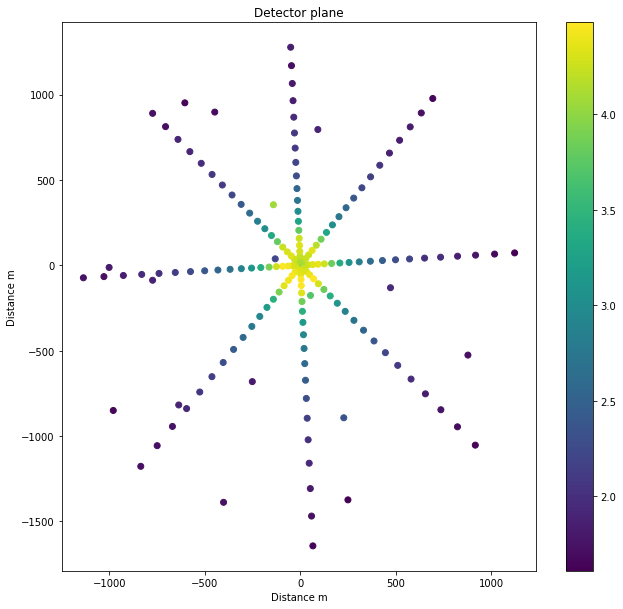

In [3]:
import numpy as np
import matplotlib.pyplot as plt
file='Stshp_Proton_3.98_38.2_90.0_22.hdf5'

ev = REvent(file)
x = np.asanyarray([a.x for a in ev.antennas])
y = np.asanyarray([a.y for a in ev.antennas])
z = np.asanyarray([a.z for a in ev.antennas])
maxVals = [np.max([np.max(a.Ex),np.max(a.Ey),np.max(a.Ez)])for a in ev.antennas]
lmaxVals=np.asanyarray( np.log10(maxVals))
cut = lmaxVals>-8

fig = plt.figure()
plt.scatter(x[cut],y[cut],c=lmaxVals[cut])
plt.colorbar()
plt.title("Detector plane")
plt.xlabel("Distance m")
plt.ylabel("Distance m")
plt.tight_layout()
fig.set_size_inches(10, 10)
fig.show()


In [4]:
Binc= np.deg2rad(ev.Binc)
np.sin(Binc)

0.8728369164014821

In [11]:
def vxvxb(zenith,azimuth,Binc):
    zenith= np.deg2rad(zenith)
    azimuth = np.deg2rad(azimuth)
    Binc= np.deg2rad(Binc)
    v = np.array([-np.sin(zenith)*np.cos(azimuth),-np.sin(zenith)*np.sin(azimuth),-np.cos(zenith)])
    # in the direction opp to the shower axis
    B = np.array([np.cos(Binc),0,-np.sin(Binc)])
    vxB=np.cross(v,B)/np.linalg.norm(np.cross(v,B))
    vxvxB=np.cross(v,vxB)/np.linalg.norm(np.cross(v,vxB))
    print('v',v)
    print('B',B)
    print('vxb',vxB)
    print('vxB',np.cross(vxvxB,v))
    print('vxb dot vxvxb =',np.dot(vxB,vxvxB))
    print('v dot vxb =',np.dot(v,vxB))
    print('v dot vxvxb =',np.dot(vxvxB,v))
    print(np.sqrt(v.dot(v)))
    print(np.sqrt(B.dot(B)))
    print(np.linalg.norm(vxB))
    print(np.linalg.norm(vxvxB))
    
       

vxvxb(ev.zenith,ev.azimuth,ev.Binc)

v [-3.78917834e-17 -6.18819784e-01 -7.85532988e-01]
B [ 0.48801201  0.         -0.87283692]
vxb [ 0.74199755 -0.52662335  0.41485839]
vxB [ 0.74199755 -0.52662335  0.41485839]
vxb dot vxvxb = 4.144173836919748e-17
v dot vxb = 7.289738929908248e-18
v dot vxvxb = 2.0071850645814784e-17
1.0
1.0
0.9999999999999999
1.0


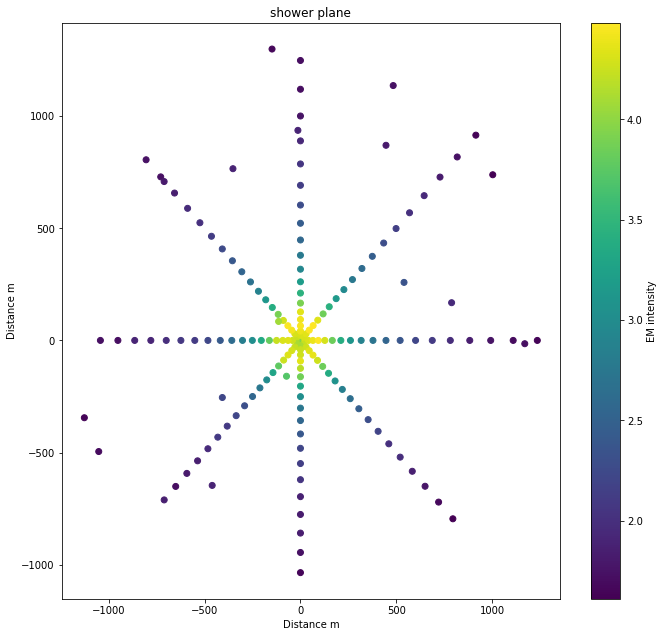

In [12]:

filename = 'Stshp_Proton_3.98_38.2_90.0_22'
# The test file, to be read
events = filename+".hdf5"
file = h5py.File(events, 'r')  # Opening a HDF5-file, for reading only

'''  v b vxb vvb '''
zenith= np.deg2rad(ev.zenith)
azimuth = np.deg2rad(ev.azimuth)
Binc= np.deg2rad(ev.Binc)
v = np.array([-np.sin(zenith)*np.cos(azimuth),-np.sin(zenith)*np.sin(azimuth),-np.cos(zenith)])
# in the direction opp to the shower axis
B = np.array([np.cos(Binc),0,-np.sin(Binc)])
vxB=np.cross(v,B)/np.linalg.norm(np.cross(v,B))
vxvxB=np.cross(v,vxB)/np.linalg.norm(np.cross(v,vxB))


''' detector plane antenna coordinates '''
proton_data = file[filename]
primary_direction = file['RunInfo']['Zenith'][0], file['RunInfo']['Azimuth'][0]
antenna_info = proton_data['AntennaInfo']
coords = np.zeros((3, len(antenna_info)))
coords[0] = antenna_info['X']
coords[1] = antenna_info['Y']
coords[2] = antenna_info['Z']-1086

''' det 2 showerplane tranformation v, (vxB), (vx(vxB)) '''
showercoords = np.zeros((3, len(antenna_info)))
showercoords[0] = vxB[0]*coords[0] + vxB[1]*coords[1] + vxB[2]*coords[2]
showercoords[1] = vxvxB[0]*coords[0] + vxvxB[1]*coords[1] + vxvxB[2]*coords[2]
showercoords[2] = v[0]*coords[0] + v[1]*coords[1] + v[2]*coords[2]


fig = plt.figure()
plt.scatter(showercoords[0],showercoords[1] ,c=lmaxVals[cut],alpha=1)
plt.colorbar(label="EM intensity")
plt.title("shower plane")
plt.xlabel("Distance m")
plt.ylabel("Distance m")
plt.tight_layout()
fig.set_size_inches(10.5, 10.5)